In [9]:
"""all necessary imports"""

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import Tensor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import cv2
import glob
import os
import random
import os
from os import listdir
from os.path import isfile, join
import keras.backend as K
AUTOTUNE = tf.data.experimental.AUTOTUNE
import re

In [2]:
img_size = [512,512]

In [68]:
#defining face classes and correspondent colours

FACE_SEM_CLASSES = [
    "background",
    "skin",
    'nose',
    'eye_g',
    'l_eye',
    'r_eye',
    'l_brow',
    'r_brow',
    'l_ear',
    'r_ear',
    'mouth',
    'u_lip',
    'l_lip',
    'hair',
    'hat',
    'ear_r',
    'neck_l',
    'neck',
    'cloth'
]

FACE_SEM_COLORS = [
    (128, 64, 128),
    (244, 35, 232),
    (70, 70, 70),
    (192, 0, 128),
    (190, 153, 153),
    (153, 153, 153),
    (250, 170, 30),
    (220, 220, 0),
    (107, 142, 35),
    (152, 251, 152),
    (70, 130, 180),
    (220, 20, 60),
    (230, 150, 140),
    (0, 0, 142),
    (0, 0, 70),
    (90, 40, 40),
    (0, 80, 100),
    (0, 254, 254),
    (0, 68, 63),
]


In [245]:
#narrowing the list of classes and colours down to what we want
face_classes = ['skin']
face_colours = []
for face_class in face_classes:
    face_colours.append(FACE_SEM_COLORS[FACE_SEM_CLASSES.index(face_class)])

In [246]:
img_path = 'D:\\face_detection_v2\\Mask_RCNN-master\\CelebAMask-HQ\\CelebA-HQ-img\\'
all_image_paths = [f for f in listdir(img_path) if isfile(join(img_path, f))]
all_image_paths = [str(img_path)+str(path) for path in all_image_paths]

all_mask_paths = all_image_paths

In [247]:
print(len(all_mask_paths))

30000


In [248]:
def load_and_preprocess_mask(path):
    return preprocess_mask(path)

In [249]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

In [250]:
def preprocess_mask(image_path):
    image_path = image_path.numpy()
    image_number = int(image_path[66:-4])
    #print(image_number)
    mask_directory_number = (int(image_number/2000))
    image_string = list('00000')
    image_string[-len(str(image_number)):] = list(str(image_number))
    image_string = (''.join(image_string))
    mask_layers = np.zeros((img_size[0],img_size[1],len(face_classes)+1))
    for i in range(len(face_classes)):
        mask_filename = str(image_string+'_'+face_classes[i]+'.png')
        mask_directory = str('D:\\face_detection_v2\\Mask_RCNN-master\\CelebAMask-HQ\\CelebAMask-HQ-mask-anno\\'+str(mask_directory_number)+'\\')
        mask_path = join(mask_directory, mask_filename)
        image = tf.io.read_file(mask_path)
        image = tf.image.decode_png(image, channels=3)
        image = image.numpy()[:,:,0]
        image = (image/255).astype(np.float32)
        mask_layers[:,:,i] = image
    
    total_mask = np.sum(mask_layers, axis=-1)
    background_mask = (total_mask==0).astype(np.float32)
    mask_layers[:,:,-1] = background_mask
    mask_layers = tf.convert_to_tensor(mask_layers, dtype=tf.float32, dtype_hint=None, name=None)
    return mask_layers

In [251]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    #only one channel needed
    image = tf.image.resize(image, img_size)
    image /= 255.0  # normalize to [0,1] range

    return image

In [252]:
#creating map of images and masks, but only their filenames
img_path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
mask_path_ds = tf.data.Dataset.from_tensor_slices(all_mask_paths)
image_ds = img_path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
mask_ds = mask_path_ds.map(lambda x: tf.py_function(preprocess_mask, [x], tf.float32), num_parallel_calls=AUTOTUNE)
image_mask_ds = tf.data.Dataset.zip((image_ds, mask_ds))
image_mask_ds = image_mask_ds.batch(5)

In [253]:
class ConvBlock(tf.keras.Model):
    def __init__(self, channels, 
                  kernel_size=3, 
                  strides=1, 
                  groups=1, 
                  bias=False,
                relu = False):
        self.relu_needed = relu
        super(ConvBlock, self).__init__()
        self.conv = tf.keras.layers.Conv2D(filters=channels, kernel_size=kernel_size, 
                                           strides=strides, padding='same',
                                          groups=groups,use_bias=bias)
        self.BN = tf.keras.layers.BatchNormalization()
        self.ReLU = tf.keras.layers.ReLU()
    
    def call(self, inputs):
        conved = self.conv(inputs)
        normed = self.BN(conved)
        if self.relu_needed:
            relued = self.ReLU(normed)
            return relued
        else:
            return normed

In [254]:
class StemBlock(tf.keras.Model):
    def __init__(self):
        super(StemBlock, self).__init__()
        self.conv1 = ConvBlock(channels = 16, strides=2)
        self.left_path = tf.keras.Sequential([
            ConvBlock(channels = 8, kernel_size=1),
            ConvBlock(channels = 16, kernel_size=3, strides=2)
        ])
        self.right_path = tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=2, padding='same')
        
        self.concat_conv = ConvBlock(channels = 16)
    
    def call(self,inputs):
        conved = self.conv1(inputs)
        left = self.left_path(conved)
        right = self.right_path(conved)
        
        concat = tf.concat((left, right), axis=-1)
        output = self.concat_conv(concat)
        return output

In [255]:
#left path:
#1 regular conv, in_chan to in_chan kernel 3
#2 DW conv, in_chan to mid_chan kernel 3 groups in_chan
#3 DW conv, mid_chan to mid_chan kernel 3 groups mid_chan
#4 Separable conv, mid_chan to out_chan kernel 1 groups 1
class GatherAndExpandBlock(tf.keras.Model):
    def __init__(self, in_channels, out_channels, strides = 1, expansion_factor=6):
        super(GatherAndExpandBlock, self).__init__()
        bottleneck_channels = int(in_channels*expansion_factor)
        self.right_exists = False
        
        if strides == 2:
            self.right_exists = True
            self.left_path = tf.keras.Sequential([
                ConvBlock(in_channels, kernel_size = 3),
                ConvBlock(bottleneck_channels, kernel_size = 3, strides = 2, groups = in_channels, relu=False),
                ConvBlock(bottleneck_channels, kernel_size = 3, groups=bottleneck_channels, relu=False),
                ConvBlock(out_channels, kernel_size=1, relu=False)
            ])

            self.right_path = tf.keras.Sequential([
                ConvBlock(bottleneck_channels, kernel_size=3, strides=2, groups=in_channels, relu=False),
                ConvBlock(out_channels, kernel_size=1, relu=False)
            ])
        
        
        else:
            self.left_path = tf.keras.Sequential([
                ConvBlock(bottleneck_channels, kernel_size = 3),
                ConvBlock(bottleneck_channels, kernel_size = 3, groups=bottleneck_channels, relu=False),
                ConvBlock(out_channels, kernel_size=1, relu=False)
            ])
    
    def call(self, inputs):
        output = self.left_path(inputs)
        if self.right_exists:
            right = self.right_path(inputs)
            output = tf.keras.layers.Add()([output, right])
        
        output = tf.keras.layers.ReLU()(output)
        
        return output
        

In [256]:
class ContextEmbeddingBlock(tf.keras.Model):
    def __init__(self, in_channels):
        super(ContextEmbeddingBlock, self).__init__()
        self.main_path = tf.keras.Sequential([
            tf.keras.layers.GlobalAveragePooling2D(keepdims=True),
            tf.keras.layers.BatchNormalization(),
            ConvBlock(channels = in_channels, strides = 1, kernel_size = 1)
        ])
        self.last_conv = ConvBlock(channels = in_channels, strides = 1, kernel_size = 3, relu=False)
    
    def call(self, inputs):
        main = self.main_path(inputs)
        added = main+inputs
        output = self.last_conv(added)
        
        return output

In [257]:
class SegmentHead(tf.keras.Model):
    #this is a model rather than layer so that weights can be saved and retrieved
    def __init__(self, in_channels, n_classes, dropout = 0.1, expansion_factor = 6, size = None):
        self.size = size
        super(SegmentHead, self).__init__()
        bottleneck_channels = in_channels*expansion_factor
        self.main_path = tf.keras.Sequential([
            ConvBlock(channels = bottleneck_channels, kernel_size = 3),
            tf.keras.layers.Dropout(dropout),
            tf.keras.layers.Conv2D(filters = n_classes, kernel_size = 1, padding='same')
        ])
        
    def call(self, inputs):
        features = inputs
        main = self.main_path(inputs)
        
        if self.size:
            upsampled = tf.image.resize(
                main,
                self.size,
                name='segmentation_head_logits'
            )
            return upsampled#tf.keras.activations.sigmoid(upsampled)
        else:
            return main#tf.keras.activations.sigmoid(main)

In [258]:
class DetailBranch(tf.keras.Model):
    def __init__(self):
        super(DetailBranch, self).__init__()
        self.s1 = tf.keras.Sequential([
            ConvBlock(channels = 64, kernel_size = 3, strides = 2),
            ConvBlock(channels = 64, kernel_size = 3, strides = 1)
        ])
        self.s2 = tf.keras.Sequential([
            ConvBlock(channels = 64, kernel_size = 3, strides = 2),
            ConvBlock(channels = 64, kernel_size = 3, strides = 1),
            ConvBlock(channels = 64, kernel_size = 3, strides = 1)
        ])
        self.s3 = tf.keras.Sequential([
            ConvBlock(channels = 128, kernel_size = 3, strides = 2),
            ConvBlock(channels = 128, kernel_size = 3, strides = 1),
            ConvBlock(channels = 128, kernel_size = 3, strides = 1)
        ])
    
    def call(self, inputs):
        s1_result = self.s1(inputs)
        s2_result = self.s2(s1_result)
        s3_result = self.s3(s2_result)
        
        return s3_result

In [259]:
class SemanticBranch(tf.keras.Model):
    def __init__(self):
        super(SemanticBranch, self).__init__()
        self.stem = StemBlock()
        self.stage_1 = tf.keras.Sequential([
            GatherAndExpandBlock(in_channels = 16, out_channels= 32, expansion_factor = 6, strides = 2),
            GatherAndExpandBlock(in_channels = 32, out_channels= 32, expansion_factor = 6, strides = 1),
        ])
        self.stage_2 = tf.keras.Sequential([
            GatherAndExpandBlock(in_channels = 32, out_channels= 64, expansion_factor = 6, strides = 2),
            GatherAndExpandBlock(in_channels = 64, out_channels= 64, expansion_factor = 6, strides = 1),
        ])
        self.stage_3 = tf.keras.Sequential([
            GatherAndExpandBlock(in_channels = 64, out_channels= 128, expansion_factor = 6, strides = 2),
            GatherAndExpandBlock(in_channels = 128, out_channels= 128, expansion_factor = 6, strides = 1),
            GatherAndExpandBlock(in_channels = 128, out_channels= 128, expansion_factor = 6, strides = 1),
            GatherAndExpandBlock(in_channels = 128, out_channels= 128, expansion_factor = 6, strides = 1),
        ])
        self.final_stage = ContextEmbeddingBlock(in_channels = 128)
    
    def call(self, inputs):
        stem_output = self.stem(inputs)
        s1_output = self.stage_1(stem_output)
        s2_output = self.stage_2(s1_output)
        s3_output = self.stage_3(s2_output)
        final_output = self.final_stage(s3_output)
        
        return stem_output, s1_output, s2_output, s3_output, final_output

In [260]:
class BilateralGuidedAggregation(tf.keras.layers.Layer):
    def __init__(self):
        super(BilateralGuidedAggregation, self).__init__()
        
        self.detail_left = tf.keras.Sequential([
            ConvBlock(128, kernel_size=3, groups=128),
            tf.keras.layers.Conv2D(filters = 128, kernel_size = 1, groups = 1, padding='same')
        ])
        self.detail_right = tf.keras.Sequential([
            ConvBlock(128, kernel_size=3, strides=2),
            tf.keras.layers.AveragePooling2D(pool_size=(3,3), strides = 2, padding='same')
        ])
        
        self.semantic_left = tf.keras.Sequential([
            ConvBlock(128, kernel_size=3),
            tf.keras.layers.UpSampling2D(size=(4, 4)),
            #tf.keras.activations.sigmoid()
        ])
        
        self.semantic_right = tf.keras.Sequential([
            ConvBlock(128, kernel_size=3, groups=128),
            ConvBlock(128, kernel_size=1)
            #tf.keras.activations.sigmoid()
        ])
        
        self.final_conv = tf.keras.Sequential([
            ConvBlock(128, kernel_size=3)
        ])
    
    def call(self, inputs):
        details, semantics = inputs
        dsize = details.shape[1:3]
        
        
        #leftmost output
        left_sem = tf.keras.activations.sigmoid(self.semantic_left(semantics))
        left_det = self.detail_left(details)
        left = left_sem*left_det
        
        #rightmost output
        right_sem = tf.keras.activations.sigmoid(self.semantic_right(semantics))
        right_det = self.detail_right(details)
        right = right_sem*right_det
        right = tf.image.resize(right, dsize)
    
        
        total = tf.keras.layers.Add()([right, left])
        output = self.final_conv(total)
        
        return output
        
        

In [261]:
class BiseNetV2_training_ver(tf.keras.Model):
    def __init__(self, n_classes, dims):
        #dims is a 1d list of 2 numbers, those being height and width of image
        super(BiseNetV2_training_ver, self).__init__()
        self.semantic = SemanticBranch()
        self.details = DetailBranch()
        self.stem_boost = SegmentHead(in_channels = 16, n_classes = n_classes, size=dims)
        self.s1_boost = SegmentHead(in_channels = 32, n_classes = n_classes, size=dims)
        self.s2_boost = SegmentHead(in_channels = 64, n_classes = n_classes, size=dims)
        self.s3_boost = SegmentHead(in_channels = 128, n_classes = n_classes, size=dims)
        self.aggregation_layer = BilateralGuidedAggregation()
        self.output_head = SegmentHead(in_channels = 128, n_classes = n_classes, size=dims)
    
    def call(self, inputs):
        stem_output, s1_output, s2_output, s3_output, final_output = self.semantic(inputs)
        stem_output = self.stem_boost(stem_output)
        s1_final = self.s1_boost(s1_output)
        s2_final = self.s2_boost(s2_output)
        s3_final = self.s3_boost(s3_output)
        details = self.details(inputs)
        combined = self.aggregation_layer([details, final_output])
        
        combined_output = self.output_head(combined)
        
        return stem_output, s1_final, s2_final, s3_final, combined_output


    def gen_dice(self, y_true, y_pred, eps=1e-6):
        """both tensors are [b, h, w, classes] and y_pred is in logit form"""

        # [b, h, w, classes]
        pred_tensor = tf.nn.softmax(y_pred, axis = -1)
        y_true_shape = tf.shape(y_true)

        # [b, h*w, classes]
        y_true = tf.reshape(y_true, [y_true_shape[0], y_true_shape[1]*y_true_shape[2], y_true_shape[3]])
        y_pred = tf.reshape(pred_tensor, [y_true_shape[0], y_true_shape[1]*y_true_shape[2], y_true_shape[3]])

        # [b, classes]
        # count how many of each class are present in 
        # each image, if there are zero, then assign
        # them a fixed weight of eps
        counts = tf.reduce_sum(y_true, axis=1)
        weights = 1. / (counts ** 2)
        weights = tf.where(tf.math.is_finite(weights), weights, eps)

        multed = tf.reduce_sum(y_true * y_pred, axis=1)
        summed = tf.reduce_sum(y_true + y_pred, axis=1)

        # [b]
        numerators = tf.reduce_sum(weights*multed, axis=-1)
        denom = tf.reduce_sum(weights*summed, axis=-1)
        dices = 1. - 2. * numerators / denom
        dices = tf.where(tf.math.is_finite(dices), dices, tf.zeros_like(dices))
        return tf.reduce_mean(dices)
    
    def dice_coef(self, y_true, y_pred, smooth=1):
        """
        Dice = (2*|X & Y|)/ (|X|+ |Y|)
             =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
        ref: https://arxiv.org/pdf/1606.04797v1.pdf
        """
        intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
        return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

    def dice_coef_loss(self,y_true, y_pred):
        return 1-self.dice_coef(y_true, y_pred)
            
    
    def train_step(self, data):
        image, segmentation = data
        with tf.GradientTape() as tape:
            stem_output, s1_output, s2_output, s3_output, combined_output = self.call(image)
            seg_outputs = [stem_output, s1_output, s2_output, s3_output]
            
            main_loss = self.gen_dice(segmentation, combined_output)
            
            seg_loss = sum([(self.gen_dice(segmentation, seg)) for seg in seg_outputs])
            seg_loss = tf.reduce_mean(seg_loss)
            #seg_loss = 0
            
            total_loss = main_loss + seg_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return({
            'total loss':total_loss, 'main loss':main_loss, 'seg_loss':seg_loss
        })
            

In [397]:
test_network = BiseNetV2_training_ver(len(face_classes)+1,img_size)

In [398]:
opt = tf.keras.optimizers.Adam(1e-4)

test_network.compile(optimizer=opt)

In [370]:
test_network.fit(image_mask_ds, epochs = 600)

Epoch 1/600
6000/6000 [==============================] - 1262s 210ms/step - total loss: 0.3933 - main loss: 0.0307 - seg_loss: 0.3627
Epoch 2/600
6000/6000 [==============================] - 1298s 216ms/step - total loss: 0.3832 - main loss: 0.0295 - seg_loss: 0.3536
Epoch 3/600
6000/6000 [==============================] - 1298s 216ms/step - total loss: 0.3755 - main loss: 0.0287 - seg_loss: 0.3468
Epoch 4/600
6000/6000 [==============================] - 1296s 216ms/step - total loss: 0.3689 - main loss: 0.0279 - seg_loss: 0.3410
Epoch 5/600
6000/6000 [==============================] - 1297s 216ms/step - total loss: 0.3637 - main loss: 0.0274 - seg_loss: 0.3363
Epoch 6/600
6000/6000 [==============================] - 1297s 216ms/step - total loss: 0.3594 - main loss: 0.0271 - seg_loss: 0.3324
Epoch 7/600
6000/6000 [==============================] - 1294s 216ms/step - total loss: 0.3558 - main loss: 0.0267 - seg_loss: 0.3291
Epoch 8/600
6000/6000 [==============================] - 1289s

KeyboardInterrupt: 

In [274]:
face_colours_visualisation = face_colours

In [275]:
print(face_colours)

[(244, 35, 232), (0, 0, 0)]


In [276]:
print(face_colours_visualisation)

[(244, 35, 232), (0, 0, 0)]


In [399]:
def segmentation_visualisation(image, just_mask=True, crop_face = False):
    mask = (test_network(image)[4].numpy().squeeze())
    maxes = np.argmax(mask, axis = -1)
    visualisation = np.zeros((np.shape(mask)[0],np.shape(mask)[1],3))
    for x in range(np.shape(visualisation)[0]):
        for y in range(np.shape(visualisation)[1]):
            visualisation[x,y] = face_colours[maxes[x,y]]
    visualisation = visualisation.astype(np.uint8)
    if just_mask == True and crop_face == False:
        return visualisation.squeeze()
    elif just_mask == False and crop_face == False:
        binary_mask = (visualisation != (0,0,0))
        final = np.where(binary_mask, visualisation, image*255)
        return final.squeeze().astype(np.uint8)
    if crop_face:
        binary_mask = (visualisation != (0,0,0))
        black_background = np.zeros((img_size[0],img_size[1],3))
        final = np.where(binary_mask, image*255, black_background)
        return final.squeeze().astype(np.uint8)

In [ ]:
for path in all_image_paths:
    image_number = (path[66:-4])
    test_img = tf.reshape(load_and_preprocess_image(path),(1,512,512,3))
    test_visualisation = segmentation_visualisation(test_img, just_mask = False, crop_face = True)
    cv2.imwrite(('D:\\face_detection_v2\\Mask_RCNN-master\\celeba-hq-crops\\'+image_number+'.jpg'), cv2.cvtColor(test_visualisation, cv2.COLOR_RGB2BGR))

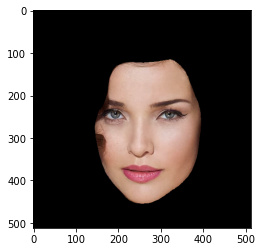

In [403]:
test_img = tf.reshape(load_and_preprocess_image(all_image_paths[random.randint(0,len(all_image_paths))]),(1,512,512,3))
test_visualisation = segmentation_visualisation(test_img, just_mask = False, crop_face = True)
plt.imshow(test_visualisation)

In [389]:
cv2.imwrite('D:\\Amphora\\test_outputs\\test_image_railsem_2.jpg', cv2.cvtColor(test_visualisation, cv2.COLOR_RGB2BGR))

True

In [645]:
renormalised_image = (test_img.numpy().squeeze()*255).astype(np.uint8)

In [647]:
cv2.imwrite('D:\\Amphora\\test_outputs\\image_railsem_1.jpg', cv2.cvtColor(renormalised_image, cv2.COLOR_RGB2BGR))

True

In [394]:
test_network.save_weights('D:\\face_detection_v2\\Mask_RCNN-master\\BiSeNetV2\\bisenetv2_face.h5')

In [402]:
test_network.load_weights('D:\\face_detection_v2\\Mask_RCNN-master\\BiSeNetV2\\bisenetv2_face.h5')